In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import os
import sys
sys.path.append("./../../pyfiles/")
from dataset import Dataset_mel
from util import *
from model import *

---

<font size="5">Overviews</font>
1. Introduction
1. Audio Dataset
1. Preparation of WaveNet-based classifier
1. Classification

---

# Introduction
---
As I mentioned in README, this experiment requires both a classifier and a generator.
The classifier with mel-spectrogram is created in this notebook
At first, I'm gonna introduce the dataset I used; 
[RAVDESS](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio) and 
[TESS](https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess).
After that, I'm gonna show the preparation and the classification.
For the sake of appearance, this notebook barely includes the functions, so please visit `pyfiles/` for further and detailed information.

---

# Dataset
---
This experiment is conducted with 2 datasets: RAVDESS and TESS.
The detail and pre-processing of the datasets are detailed in `A_preprocesssing_TESS_and_RAVDESS.ipynb`

---

---
At first, I defined some valuables and functions.

---

In [4]:
# ----- adjustable parameters ----- #
emotions = ["neutral", "happy", "sad", "angry"] # the labels of classes
classes = tuple(range(len(emotions))) # classes tuple
target_length = 2**15 # data length, about 1.5 seconds
fs = 22050 # samling rate
root_TESS = "../../../dataset/TESS/preprocessed/" # root path of the TESS dataset
root_RAVDESS = "../../../dataset/RAVDESS/preprocessed/" # root path of the RAVDESS dataset
# --------------------------------- #

---
Let's see some examples.

---

In [5]:
dataset = Dataset_mel(root_TESS, root_RAVDESS, transform_mel, emotions, target_length, mode="all", dataset="both")
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

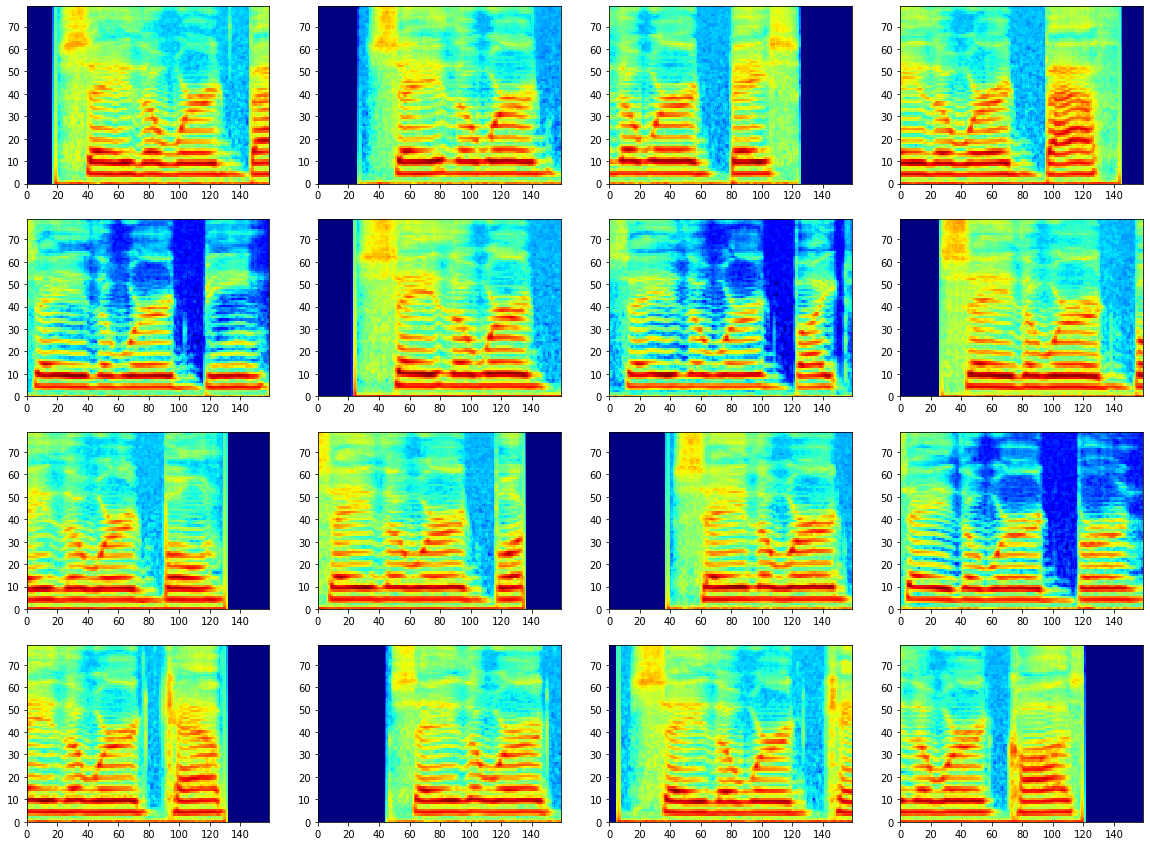

In [6]:
fig = plt.figure(figsize=(20, 15))
for i in range(16):
    data = dataloader.dataset[i]
    M = data[0].numpy()[0]
    plot_spectrogram(M, fig, (4,4,i+1))

# Preparation of Classification
---
Ok, so let's take a look at the conditions of training and some functions.

---

First of all, in order to focus on training process in the main code, I first implemented the function for test process.

---

In [7]:
def do_test(net, testloader, device="cuda", mode="eval"):
    if mode=="train":
        net.train()
    elif mode=="eval":
        net.eval()
    else:
        return None
    outputs = np.zeros((1, len(classes)))
    labels = np.array([])
    with torch.no_grad():
        for itr, data in enumerate(testloader):
            images = data[0].to(device)
            label = data[1].to(device)
            output = F.softmax(net(images), dim=1)
            labels = np.append(labels, label.to("cpu").detach().numpy())
            outputs = np.concatenate([outputs, output.to("cpu").detach().numpy()], axis=0)
    return labels, outputs[1:, :]

---
Well, next, some hyperparameters for training are mentioned in the cell below.

---

In [8]:
# ----- adjustable parameters ----- #
epoch_num = 301
lr = 0.001
torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
# --------------------------------- #

---
I'm going to compare the performance of 3 models: a CNN-LSTM based model, a WaveNet-based model, and a CNN-based model. 
You can choose either 'lstm', 'wavenet', or 'cnn' at the first line and the others are related to hyper-parameters of a selected model.

---

In [14]:
# ----- adjustable parameters ----- #
model_type = "cnn" # choices are 'wavenet', 'lstm', or 'cnn'

if model_type=="wavenet":
    layer_num = 5
    resnch_in = 16 # the input channels in residual block
    resnch_hidden = int(resnch_in/2) # the hidden channels in residual block
    resnch_out = resnch_hidden * 2 # the output channels in residual block
    nch_hidden = resnch_out * 2 # the hidden channels in stack-CNN layers following the residual block
    nch_out = len(classes) # the output channels, # of classes
    reduce = 2 # kernel size of max pooling layer
    nch_in = 80 # input channels
    prefilter = 3 # kernel size of the pre-convolutional layer
    filter_list = [3] * layer_num # filter size of the convolutional layers
    dilation_list = [2**i for i in range(10)] * (layer_num//10) + [2**i for i in range(layer_num%10)] # dilation in ResudualNet
    num_cls = 3 # # of layer in stach-CNN layers
    bidirectional = True # bi-directional or not
    
elif model_type=="lstm":
    nch = 64
    lstm_in_nch = int(nch/2)
    pre_filter_kernel = 3
    reduce = 2 # compression size in each CNN layers
    num_cls = 1 # # of layer in stach-CNN layers
    bidirectional = True # bi-directional or not
    num_lstm_layers = 5
    
elif model_type=="cnn":
    layer_num = 3
    nch = 64
# --------------------------------- #
if model_type=="wavenet" or model_type=="lstm":
    bi_or_uni = "bi" if bidirectional else "uni"

---
some algorithms are employed for optimization, loss function, and scheduler.
- optimizer: Adam optimizer with default parameters
- scheduler: learning rate scheduler which lowers the lr exponentially
- loss function: Cross Entropy Loss (CELoss)

---

In [20]:
if model_type=="wavenet":
    net = WaveNet_classifier_mel(resnch_in, resnch_hidden, resnch_out, nch_hidden, nch_out, 
                             filter_list, dilation_list, 160, reduce, num_cls, prefilter, nch_in, bidirectional)
elif model_type=="lstm":
    net = LSTM_classifier_mel(80, len(classes), nch, bidirectional, num_cls, reduce, num_lstm_layers, 
                          160, pre_filter_kernel, lstm_in_nch)
elif model_type=="cnn":
    net = CNN_classifier_mel(1, len(classes), layer_num, nch)
net = net.to(device)
net.apply(weights_init)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()

In [22]:
# ----- adjustable parameters ----- #
model_type = "wavenet" # choices are 'wavenet', 'lstm', or 'cnn'

if model_type=="wavenet":
    layer_num = 5
    resnch_in = 16 # the input channels in residual block
    resnch_hidden = int(resnch_in/2) # the hidden channels in residual block
    resnch_out = resnch_hidden * 2 # the output channels in residual block
    nch_hidden = resnch_out * 2 # the hidden channels in stack-CNN layers following the residual block
    nch_out = len(classes) # the output channels, # of classes
    reduce = 2 # kernel size of max pooling layer
    nch_in = 80 # input channels
    prefilter = 3 # kernel size of the pre-convolutional layer
    filter_list = [3] * layer_num # filter size of the convolutional layers
    dilation_list = [2**i for i in range(10)] * (layer_num//10) + [2**i for i in range(layer_num%10)] # dilation in ResudualNet
    num_cls = 3 # # of layer in stach-CNN layers
    bidirectional = True # bi-directional or not
    
elif model_type=="lstm":
    nch = 64
    lstm_in_nch = int(nch/2)
    pre_filter_kernel = 3
    reduce = 2 # compression size in each CNN layers
    num_cls = 1 # # of layer in stach-CNN layers
    bidirectional = True # bi-directional or not
    num_lstm_layers = 5
    
elif model_type=="cnn":
    layer_num = 3
    nch = 64
# --------------------------------- #
if model_type=="wavenet" or model_type=="lstm":
    bi_or_uni = "bi" if bidirectional else "uni"
    
if model_type=="wavenet":
    net = WaveNet_classifier_mel(resnch_in, resnch_hidden, resnch_out, nch_hidden, nch_out, 
                             filter_list, dilation_list, 160, reduce, num_cls, prefilter, nch_in, bidirectional)
elif model_type=="lstm":
    net = LSTM_classifier_mel(80, len(classes), nch, bidirectional, num_cls, reduce, num_lstm_layers, 
                          160, pre_filter_kernel, lstm_in_nch)
elif model_type=="cnn":
    net = CNN_classifier_mel(1, len(classes), layer_num, nch)

---
This is the preparation of the dataset

---

In [21]:
# ----- adjustable parameters ----- #
train_batch = 512
val_batch = 512
# --------------------------------- #

dataset = Dataset_mel(root_TESS, root_RAVDESS, transform, emotions, target_length, mode="train", dataset="both")
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_mel(root_TESS, root_RAVDESS, transform, emotions, target_length, mode="val", dataset="both")
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=True)
len(dataset), len(valset)

(2000, 232)

# Classification
---
Let's train your model.
The notebook gives you the losses and the accuracies of every epoch.
What's more, it stocks the best epoch for the validation dataset, so call it when the training is finished.

---

300
test acc in 300 : 0.896551724137931
best acc is   : 0.9094827586206896 in epoch243


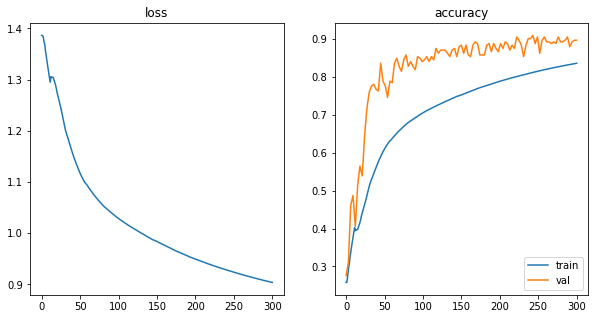

In [36]:
net.train()
losses = []
losses_epoch = []
accs = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        y = F.softmax(net(x), dim=1)
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        loss = loss.to("cpu").detach().numpy()
        label = label.to("cpu").detach().numpy()
        y = y.to("cpu").detach().numpy()
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    scheduler.step()
    if epoch%test_interval==0:
        labels, outputs = do_test(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            if model_type=="wavenet":
                param_path = f"../instant_model_parameter/mel_emotion_classifier_{bi_or_uni}wavenet_nchin{nch_in}_prefilter{prefilter}_res_in{resnch_in}_hidden{resnch_hidden}_out{resnch_out}_nchhidden{nch_hidden}_nchout{nch_out}_wavenetln{layer_num}_fsize{filter_list[0]}_reduce{reduce}_cnnnum{num_cls}_epoch{epoch}.pth"
            elif model_type=="lstm":
                param_path = f"../instant_model_parameter/mel_emorec_fs{fs}_{bi_or_uni}lstm_nch{nch}_cnnnums{num_cls}_reduce{reduce}_prefilter{pre_filter_kernel}_lstmin{lstm_in_nch}_lstmnum{num_lstm_layers}_epoch{epoch}.pth"
            elif model_type=="cnn":
                param_path = f"../instant_model_parameter/mel_emotion_classifier_CNN_layer_num{layer_num}_nch{nch}_epoch{epoch}.pth"
            torch.save(net.state_dict(), param_path)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

## Result
---
Since this is a lengthy process, I've finished training and saved the parameters of the best validation accuracy in advance.
Let's call it in the code below.


---

In [23]:
load_parameter = True
if load_parameter:
    if model_type == "lstm":
        ##### LSTM ######
        model_path = f"../data/parameters/mel_emorec_fs22050_bilstm_nch64_cnnnums1_reduce2_prefilter3_lstmin32_lstmnum5_epoch279.pth"
    elif model_type == "wavenet":
        ##### WaveNet ###
        model_path = f"../data/parameters/mel_emotion_classifier_biwavenet_nchin80_prefilter3_res_in16_hidden8_out16_nchhidden32_nchout4_wavenetln5_fsize3_reduce2_cnnnum3_epoch192.pth"
    elif model_type == "cnn":
        ###### CNN ######
        model_path = f"../data/parameters/mel_emotion_classifier_CNN_layer_num3_nch64_epoch273.pth"
    model = torch.load(model_path)
    net.load_state_dict(model)

---
This is the test dataset. Of course, this is separated from the training and the validation dataset.

---

In [24]:
# ----- adjustable parameters ----- #
test_batch = 512
# --------------------------------- #

testset = Dataset_mel(root_TESS, root_RAVDESS, transform, emotions, target_length, mode="test", dataset="both")
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=test_batch, shuffle=False)

---
Evaluate it many times.

---

In [25]:
# ----- adjustable parameters ----- #
test_num = 100
# --------------------------------- #

acc_list = []
cm_list = []
for i in range(test_num):
    print(i)
    labels, outputs = do_test(net, testloader, device, "eval")
    pred_labels = np.argmax(outputs, axis=1) 
    acc_test = accuracy_score(labels, pred_labels)
    acc_list.append(acc_test)
    cm = confusion_matrix(labels, pred_labels, labels=np.arange(len(classes)))
    cm_list.append(cm)
    clear_output(wait=True)
print(f"test acc is : {np.mean(acc_list)}")
print(f"test acc's std is : {np.std(acc_list)}")

test acc is : 0.8296120689655174
test acc's std is : 0.009969017849550734


---
Check the detail (confusion matrix)

---

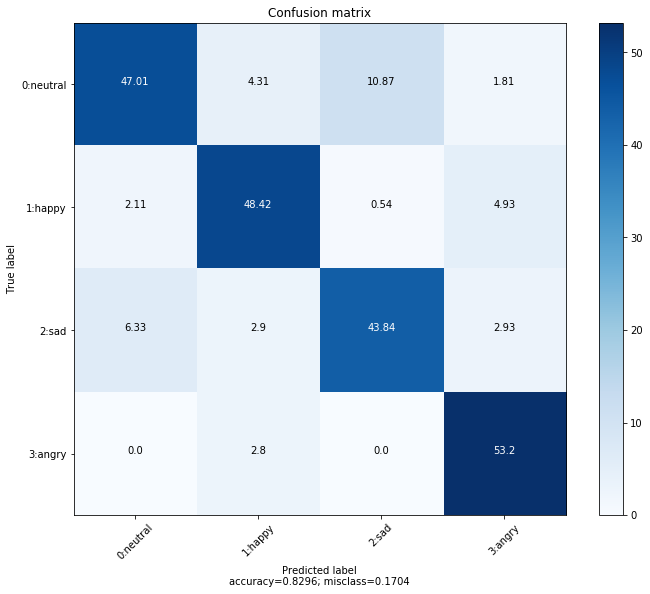

In [26]:
class_idx_lbl = emotions.copy()
for i in range(len(emotions)):
    class_idx_lbl[i] = f"{i}:{emotions[i]}"
        
cm = np.mean(np.array(cm_list), axis=0)
plot_confusion_matrix(cm, class_idx_lbl, normalize=False)

---
The accuracy is quite good enough.
As the result, "neutral" voice sometimes classified as "sad".

---

## Misclassification


the samples of 'neutral' which are classified as 'happy''



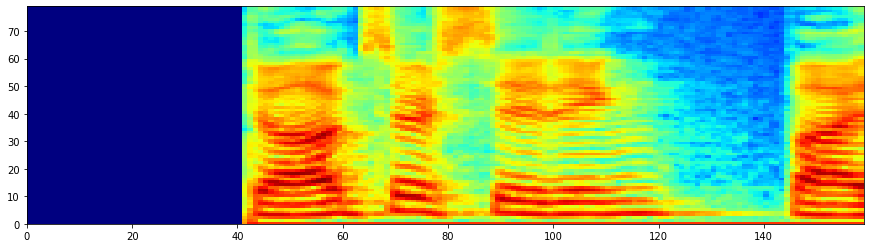

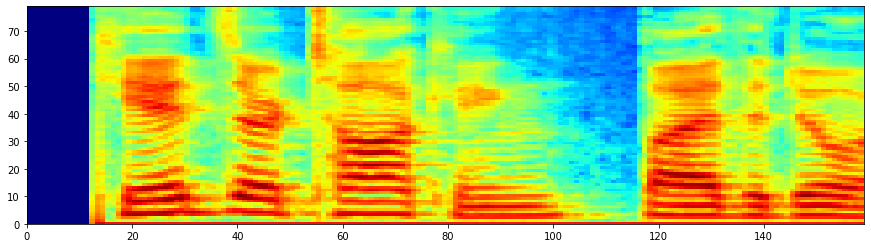

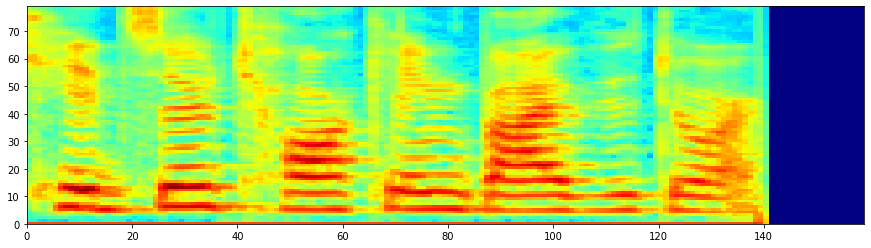

In [30]:
# ----- adjustable parameters ----- #
true_class = 0
misclassified_class = 1
display_num = 10
# --------------------------------- #

print("")
print(f"the samples of '{emotions[true_class]}' which are classified as '{emotions[misclassified_class]}''")
print("")
for i in np.arange(len(labels))[np.array(np.array(pred_labels==misclassified_class, dtype=np.int) * np.array(labels==true_class, dtype=np.int), dtype=np.bool)][:display_num]:
    fig = plt.figure(figsize=(15, 4))
    data = testset[i]
    M = data[0].numpy()[0]
    plot_spectrogram(M, fig, (1,1,1))
    plt.show()